<a href="https://colab.research.google.com/github/ericfruchi/Portfolio/blob/master/An%C3%A1lise_de_Dados_Est%C3%A1dios_pelo_Mundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'football-stadiums:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3921263%2F6817400%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T002121Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6f1f2b073bdf3afb6a13995083bb6d3a6f2e46d2ac11f1fb37693553ab96b5a0209e3d323ffa024d52509823f4226c07b0e2467d589e1aecd108c8ae78b9a837a63c310f1ea21fece767d72baf35a92435a6b55a219d2aec004fb5f17cad98430291bb65455ff3b1131fe4d50d51ed2dd81368e858837c08d89e06eca3ec672aa16de327d5da4a6cafd7cca840c7df22c63800cf310bbc1d054540bcac39e7ed66d552813d45ea1d2844c18ee9ca0e37f0da8939bb34639c27b7a1b40469ef16cd18f4baa379e5358821cfbcae738a8003145c4a15fa0cf41fdf006012cd5a9915545a1e449e94cf87345882d4f4e5ff45c09a93a2fa008d9b652d6595a52065'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-stadiums/Football Stadiums.csv


#  **Analisando os Estádios Pelo Mundo**

No cenário mundial contemporâneo, os estádios representam não apenas espaços de competição esportiva, mas também pontos focais de encontros culturais, entretenimento e identidade local. Neste projeto de análise de dados em Python, mergulharemos na vasta coleção de informações sobre estádios em todo o mundo, com o objetivo de identificar padrões, tendências e insights significativos, fica o adendo que nossa análise abrangerá não apenas estádios, mas também autódromos ou recintos de grandes dimensões especializados em receber grandes eventos, principalmente esportivos.

Desde as majestosas arenas que abrigam partidas de futebol até os estádios multifuncionais que hospedam concertos e eventos diversos, o panorama dos estádios é diversificado e dinâmico. Nosso foco será utilizar técnicas de análise de dados para explorar diversos aspectos, incluindo capacidade, localização geográfica, quantidade de estádios por continente, país ou confederação e muito mais.

**Nosso objetivo principal será identificar padrões emergentes e tendências significativas que nos permitam compreender melhor a natureza dos estádios ao redor do mundo.**

Por meio dessa análise, esperamos não apenas obter insights valiosos sobre a paisagem dos estádios pelo mundo, mas também usar o poder da análise de dados em uma jornada de descoberta para desvendar os segredos e as características dos estádios que moldam nossa experiência global.

Vamos explorar juntos o fascinante mundo dos estádios, guiados pela análise de dados e pela curiosidade infindável!
O dataset que trabalharemos aqui trata-se de uma amostra de estadios aos redor do mundo, ele foi disponibilizado na plataforma [Kaggle](https://www.kaggle.com/) no final de 2023 e você pode encontrá-lo [aqui](https://www.kaggle.com/datasets/imtkaggleteam/football-stadiums).


<left><img alt="stadiums in the world" width="100%" src="https://images.unsplash.com/photo-1628542751565-c31603f19e2a?q=80&w=1470&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"></left>
<figcaption style="font-size: 14px; color: #888; text-align: left;">📍Olympistadion, Berlim, Alemanha</figcaption>

Antes de tudo vamos declarar nosso dicionário de variáveis:
* Confederation - Confederação;
* Stadium - Estádio;
* City - Cidade;
* HomeTeams - Time Mandante;
* Capacity - Capacidade;
* Country - País;
* IOC - Sigla do Páis;
* Population - População;
* Continent - Continente*;
* Capacity per Population - Capacidade por População*.

*colunas criadas

Chegou o momento de importar as bibliotecas e de ler as primeiras linhas do dataset. Outra informação importante para nossa análise, é que cada linha do dataset se refere a um estádio, isso é muito importante para organizarmos nossa análise.

In [7]:
# importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ler dataset
df = pd.read_csv('/kaggle/input/football-stadiums/Football Stadiums.csv')


## Exploração dos Dados
Hora de explorar os dados e entender o que nos espera.

In [8]:
# ler primeiras entradas
df.head()

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population
0,UEFA,Stadiumi Besëlidhja,Lezhë,Besëlidhja,7000,Albania,ALB,2876591
1,UEFA,Stadiumi Flamurtari,Vlorë,Flamurtari Vlorë,8200,Albania,ALB,2876591
2,UEFA,Stadiumi Laçi,Laçi,KF Laçi,5000,Albania,ALB,2876591
3,UEFA,Stadiumi Niko Dovana,Durrës,Teuta,12040,Albania,ALB,2876591
4,UEFA,Stadiumi Selman Stërmasi,Tirana,"KF Tirana, Dinamo, Partizani",9500,Albania,ALB,2876591


In [9]:
# medidas do DataFrame
df.shape

(2024, 8)

Até aqui, o DataFrame possui 2024 linhas e 8 colunas.

In [10]:
# detalhes do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Confederation  2024 non-null   object
 1   Stadium        2024 non-null   object
 2   City           2024 non-null   object
 3   HomeTeams      2024 non-null   object
 4   Capacity       2024 non-null   int64 
 5   Country        2024 non-null   object
 6   IOC            2024 non-null   object
 7   Population     2024 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 126.6+ KB


A função`.info()` apresenta muitos detalhes de nossas variáveis, é possível visualizar seus tipos, que no nosso caso parecem estar adequadas e se há dados ausentes, o que não é o nosso caso. Algo me diz que teremos pouca necessidade de limpar os dados do nosso DataFrame, tarefa bem comum para todo analista de dados e que confesso gostar muito.

In [11]:
# detalhes do DataFrame de nossas variáveis numéricas
df.describe()

,Capacity,Population
count,2024.000000,2.024000e+03
mean,22905.075099,9.964931e+07
std,20728.566347,2.326112e+08
min,244.000000,3.219400e+04
25%,7477.750000,1.029103e+07
50%,16408.000000,3.843360e+07
75%,32004.750000,8.081052e+07
max,153000.000000,1.403500e+09


Nosso DataFrame possui apenas duas variávies numéricas, `Capacity` e `Population`. Isso me deu uma ideia, já que `Capacity` representa a capacidade do estádio e `Population` a população do país a qual ele pertence... vamos criar uma coluna chamada: `Capacity_per_Population`, ela representará a porcentagem da população que o estádio consegue receber. Ideia levantada, agora seguimos com nossa primeira tarefa, que é criar a coluna `Continent`.

Com o intuito de criarmos uma nova coluna chamada "Continent", onde nele informará a qual continente perterce o estádio. Vamos visualizar quais confederações únicas possui nosso DataFrame. Para isso vamos usar a função `.unique()`.

In [12]:
# tipos de confederação
print(df['Confederation'].unique())

['UEFA' 'CAF' 'CONMEBOL' 'AFC' 'CONCACAF' 'OFC']


OK! Através de uma análise qualitativa, conseguimos destrinchar as siglas e chegamos a qual continente essas confederações pertencem:
* **UEFA** - União das Associações Europeias de Futebol;
* **CAF** - Conferação Africana de Futebol;
* **CONMEBOL** - Confederação Sul-Americana de Futebol;
* **AFC** - Confederação Asiática de Futebol ;
* **CONCACAF** - Confederação de Futebol da América do Norte, Central e Caribe;
* **OFC** - Confederação de Futebol da Oceania.

Agora por meio da função `.map()` vamos criar a coluna `Continent` através da coluna `Confederation`.

In [13]:
# Criar coluna Continent
# Mapeamento das siglas para os continentes
continent_map = {
    'UEFA': 'Europa',
    'CAF': 'Africa',
    'CONMEBOL': 'America do Sul',
    'AFC': 'Asia',
    'CONCACAF': 'América do Norte, Central e Caribe',
    'OFC': 'Oceania'
}

# Adicionando a nova coluna 'continent' ao DataFrame
df['Continent'] = df['Confederation'].map(continent_map)

# Exibindo o DataFrame resultante
display(df.head())
display(df["Continent"].unique())

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent
0,UEFA,Stadiumi Besëlidhja,Lezhë,Besëlidhja,7000,Albania,ALB,2876591,Europa
1,UEFA,Stadiumi Flamurtari,Vlorë,Flamurtari Vlorë,8200,Albania,ALB,2876591,Europa
2,UEFA,Stadiumi Laçi,Laçi,KF Laçi,5000,Albania,ALB,2876591,Europa
3,UEFA,Stadiumi Niko Dovana,Durrës,Teuta,12040,Albania,ALB,2876591,Europa
4,UEFA,Stadiumi Selman Stërmasi,Tirana,"KF Tirana, Dinamo, Partizani",9500,Albania,ALB,2876591,Europa


array(['Europa', 'Africa', 'America do Sul', 'Asia',
       'América do Norte, Central e Caribe', 'Oceania'], dtype=object)

Como podemos ver, a coluna `Continent` foi criada. Mas por qual motivo para criar essa coluna?? A ideia foi melhorar o senso de geolocalização continental dos estádios, temos as informações de cidades e país e não tinha a informação de seu continente, era possível identificar isso através da coluna confederação, era só ligar os pontos, mas nossa análise vai atingir um público abrangente, onde visualizar somente por confederação dificultaria muito entendimento por boa parte deles. Nem todos sabem que a OFC é a Confederação de Futebol da oceania.

Falando sobre oceania... É sabido que a Austrália participa das eliminatórias da copa do mundo pela confederaçào asiática, portanto, como usamos a variável `Confederation` para criar a coluna `Continent` os australianos devem estar sendo representados pelo continente asiático no nosso DataFrame. Vamos confirmar isso abaixo.

In [14]:
# identificar detalhes Australia
df[df["Country"] == "Australia"]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent
40,AFC,AAMI Park,Melbourne,Melbourne Victory,30050,Australia,AUS,25150200,Asia
41,AFC,Allianz Stadium,Paddington,"Roosters, Waratahs, Sydney FC",45500,Australia,AUS,25150200,Asia
42,AFC,ANZ Stadium,Sydney,-,83500,Australia,AUS,25150200,Asia
43,AFC,Bluetongue Stadium,Gosford,Mariners,20059,Australia,AUS,25150200,Asia
44,AFC,Cbus Super Stadium,Robina,Gold Coast United,27400,Australia,AUS,25150200,Asia
45,AFC,Coopers Stadium,Hindmarsh,Adelaide United,17000,Australia,AUS,25150200,Asia
46,AFC,GIO Canberra Stadium,Canberra,-,25011,Australia,AUS,25150200,Asia
47,AFC,Hunter Stadium,Newcastle,"Jets, Knights",33000,Australia,AUS,25150200,Asia
48,AFC,Marvel Stadium,Melbourne,Melbourne Victory,56347,Australia,AUS,25150200,Asia
49,AFC,Melbourne Cricket Ground,Melbourne,-,100024,Australia,AUS,25150200,Asia


Exatamente como imaginavámos, após as mudanças em nosso DataFrame a Austrália ficou situada no continente asiático, não há problema mantê-los pertencentes a confederação asiática, mas ao continente oriental sim e é isso que vamos resolver agora.

In [15]:
# Alterar o continente para Oceania onde o país for Austrália
df.loc[df["Country"] == "Australia", "Continent"] = "Oceania"

# Verificar se a alteração foi feita corretamente
df[df["Country"] == "Australia"]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent
40,AFC,AAMI Park,Melbourne,Melbourne Victory,30050,Australia,AUS,25150200,Oceania
41,AFC,Allianz Stadium,Paddington,"Roosters, Waratahs, Sydney FC",45500,Australia,AUS,25150200,Oceania
42,AFC,ANZ Stadium,Sydney,-,83500,Australia,AUS,25150200,Oceania
43,AFC,Bluetongue Stadium,Gosford,Mariners,20059,Australia,AUS,25150200,Oceania
44,AFC,Cbus Super Stadium,Robina,Gold Coast United,27400,Australia,AUS,25150200,Oceania
45,AFC,Coopers Stadium,Hindmarsh,Adelaide United,17000,Australia,AUS,25150200,Oceania
46,AFC,GIO Canberra Stadium,Canberra,-,25011,Australia,AUS,25150200,Oceania
47,AFC,Hunter Stadium,Newcastle,"Jets, Knights",33000,Australia,AUS,25150200,Oceania
48,AFC,Marvel Stadium,Melbourne,Melbourne Victory,56347,Australia,AUS,25150200,Oceania
49,AFC,Melbourne Cricket Ground,Melbourne,-,100024,Australia,AUS,25150200,Oceania


Perfeito! Agora nosso DataFrame representa mais a realidade (que é sempre o ideal para qualquer análise): Austrália localizada no continente da oceania, mas pertencente a confederação asiática. Parece ser pouca coisa, mas isso afetará em muitas métricas na etapa de análise de dados. Seguimos com a etapa de exploração de dados.

Nossa exploração dos dados não para por aqui, lembram que falamos sobre uma nova coluna chamada `Capacity_per_Population`? Onde ela vai armenzar a porcentagem da população do país que o estádio consegue receber? E ela que vamos criar agora.

In [16]:
# Criar coluna Capacity per Population
df['Capacity_per_Population'] = df['Capacity'] / df['Population']* 100

# exibir primeiras entradas
display(df.head())

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
0,UEFA,Stadiumi Besëlidhja,Lezhë,Besëlidhja,7000,Albania,ALB,2876591,Europa,0.243344
1,UEFA,Stadiumi Flamurtari,Vlorë,Flamurtari Vlorë,8200,Albania,ALB,2876591,Europa,0.285060
2,UEFA,Stadiumi Laçi,Laçi,KF Laçi,5000,Albania,ALB,2876591,Europa,0.173817
3,UEFA,Stadiumi Niko Dovana,Durrës,Teuta,12040,Albania,ALB,2876591,Europa,0.418551
4,UEFA,Stadiumi Selman Stërmasi,Tirana,"KF Tirana, Dinamo, Partizani",9500,Albania,ALB,2876591,Europa,0.330252


Parece que nosso DataFrame está ficando maior, somado a coluna `Continent`, agora também temos a coluna `Capacity_per_Population`, assim como `Continent` ajudará com o senso de geolocalização continental, `Capacity_per_Population` nos dará o melhor senso de proporção da capacidade do estádio para com o seu pais, isso pode nos trazer números/insights bem interessantes.

Vamos visualizar os números do nosso novo DataFrame.

In [17]:
# Medidas do DataFrame após as colunas adicionadas
print("Novas medidas do DataFrame: ", df.shape)
print(df.info())

Novas medidas do DataFrame:  (2024, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confederation            2024 non-null   object 
 1   Stadium                  2024 non-null   object 
 2   City                     2024 non-null   object 
 3   HomeTeams                2024 non-null   object 
 4   Capacity                 2024 non-null   int64  
 5   Country                  2024 non-null   object 
 6   IOC                      2024 non-null   object 
 7   Population               2024 non-null   int64  
 8   Continent                2024 non-null   object 
 9   Capacity_per_Population  2024 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 158.2+ KB
None


Seguimos com as mesmas 2024 linhas, mas agora com 10 colunas.
`Continent` recebeu o tipo *object* e `Capacity_per_Population` o tipo *float*, ambos corretos para nosso projeto.

## Análise dos Dados
Tudo tem um processo, Após uma profunda exploração dos dados (o que não deixa de ser uma análise), pouca ou zero necessidade de limpar os dados e de novas colunas, chegou a hora de analisar os dados e colher os mais diversos insights para responder nossas perguntas.

Iniciamos nossa análise tentando entender o volume de países que atinge nossa análise e vamos entender como eles estão distribuídos entre os continentes.

In [18]:
# país por continente
df.groupby('Continent')['Country'].nunique().sort_values(ascending=False)

Continent
Europa                                52
Asia                                  31
Africa                                27
America do Sul                        10
América do Norte, Central e Caribe     7
Oceania                                2
Name: Country, dtype: int64

A maioria dos países vem da **europa**, são 52 países, depois temos a **ásia** com 32 países, a **áfrica** vem na sequência com 27, depois temos a **américa do sul** com 10 países, **américa do norte, central e caribe** com 7 e finalizando aparece a **oceania** representado com apenas e países.

Identificamos que todos os continentes estão representados em nossa análise, aproveitando isso, vamos ver mais alguns números gerais

In [19]:
# número gerais do
country_count = df["Country"].nunique()
conf_count = df["Confederation"].nunique()
continent_count = df["Continent"].nunique()
hometeam_count = df["HomeTeams"].nunique()
stadium_count = df["Stadium"].count()

print(country_count,"países registrados no DataFrame")
print(conf_count, "confederações registradas no DataFrame")
print(continent_count, "continentes registrados no DataFrame")
print(hometeam_count, "times presentes no DataFrame")
print(stadium_count, "estádios registrados no DataFrame")

129 países registrados no DataFrame
6 confederações registradas no DataFrame
6 continentes registrados no DataFrame
1636 times presentes no DataFrame
2024 estádios registrados no DataFrame


Há mais estádios do que time, ao todo são 1993 estádios únicos registrados em nosso DataFrame e 1636 times, mas há algumas hipóteses para isso,a primeira é que tem registros de nomes/apelidos iguais na coluna `HomeTeams` por isso não entraram nos números de times únicos. Usaremos o exemplo do time com nome de "Tigers" para ilustrar nossa explicação.


In [20]:
# filtrando equipes com o nome Tigers
df[df['HomeTeams'] == "Tigers"]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
1898,CONCACAF,Clemson Memorial Stadium,Clemson,Tigers,81500,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.025022
1904,CONCACAF,Faurot Field,Columbia,Tigers,71168,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.021849
1918,CONCACAF,Jordan-Hare Stadium,Auburn,Tigers,87451,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.026849
1930,CONCACAF,Liberty Bowl,Memphis,Tigers,59308,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.018208
1956,CONCACAF,Princeton Stadium,Princeton,Tigers,27773,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.008527
1982,CONCACAF,Tiger Stadium,Baton Rouge,Tigers,102321,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.031414


Apesar da coluna `HomeTeams` registrar o nome Tigers varias vezes, são times de cidades, capacidade e estádios diferentes. Por isso a diferença nos números.

A segunda hipótese é que também na coluna `HomeTeams` há registros somente com o traço "-". Vamos ver isso a seguir.



In [21]:
# filtro estádios sem time da casa
df[df["HomeTeams"] == "-"]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
14,CAF,Estádio 11 de Novembro,Kilamba Kiaxi,-,50000,Angola,ANG,25789024,Africa,0.193881
28,CONMEBOL,Estadio Malvinas Argentinas,Mendoza,-,40268,Argentina,ARG,43847430,America do Sul,0.091837
30,CONMEBOL,Estadio Mario Alberto Kempes,Cordoba,-,57000,Argentina,ARG,43847430,America do Sul,0.129996
34,CONMEBOL,Estadio Único,Villa Mercedes,-,28000,Argentina,ARG,43847430,America do Sul,0.063858
42,AFC,ANZ Stadium,Sydney,-,83500,Australia,AUS,25150200,Oceania,0.332005
...,...,...,...,...,...,...,...,...,...,...
1964,CONCACAF,RFK Stadium,Washington,-,56692,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.017405
1975,CONCACAF,Stadium Bowl,Tacoma,-,15000,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.004605
1998,CONMEBOL,Estadio Centenario,Montevideo,-,65235,Uruguay,URU,3444006,America do Sul,1.894160
2015,AFC,My Dinh Stadium,Hanoi,-,40192,Vietnam,VIE,94569072,Asia,0.042500


In [22]:
# filtro estádios sem time da casa - cálculo de linhas filtradas
homelessteams = (df["HomeTeams"] == "-").sum()
print(homelessteams, "estádios não tem um time para chamar de seu oficialmente.")

204 estádios não tem um time para chamar de seu oficialmente.


Tudo isso colaborou para a diferença entre o número de estádios e times em nosso DataFrame.

Dúvidas criadas, hipóteses levantadas e exibidas. Agora seguiremos nossa análise identificano o maior e o menor estádio em números de capacidade de público.

In [23]:
# estádio com maior capacidade de público
df.groupby("Stadium")["Capacity"].max().sort_values(ascending=False).head(1)

Stadium
Bristol Motor Speedway    153000
Name: Capacity, dtype: int64

O estádio com maior capacidade do nosso DataFrame é o **Bristol Motor Speedway**, é um autódromo oval localizado em Bluff City no estado do Tennessee nos Estados Unidos. Construído em 1960 ele se tornou um dos mais populares circuitos americanos com 153 mil lugares.

In [24]:
# estádio com menor capacidade de público
df.groupby("Stadium")["Capacity"].min().sort_values(ascending=False).tail(1)

Stadium
Stadion OSiR Skałka    244
Name: Capacity, dtype: int64

O estádio com a menor capacidade de público registrado em nosso DataFrame é o **Stadion OSir Skałka**, com 244 lugares. Na verdade, assim como o Bristol Motor Speedway também é um autódromo, só que também é um estádio de futebol, ele fica localizado no centro de Świętochłowice, na Polônia.

Seguindo com essa proposta, vamos identificar quais são os maiores e menores estádios por continente, e faremos isso usando a função `pivot_table()`

In [25]:
# pivot table # capacidade máxima e mínima por continente
df.pivot_table(values="Capacity", index="Continent", aggfunc=["max", "min"])

,max,min
,Capacity,Capacity
Continent,,
Africa,94736,5000
America do Sul,80093,952
"América do Norte, Central e Caribe",153000,500
Asia,114000,3000
Europa,99354,244
Oceania,100024,5000


...
Vamos visualizar essa informação através de um gráfico

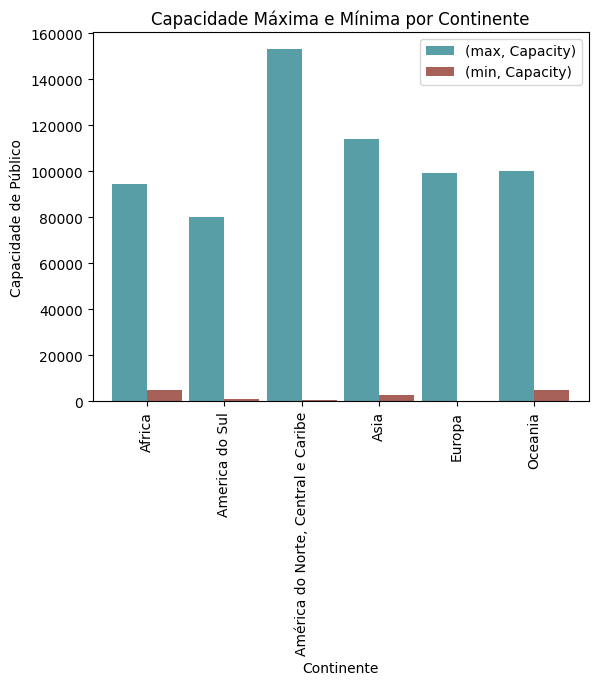

In [26]:
# pivot table # capacidade máxima e mínima por continente - chart
df.pivot_table(values="Capacity", index="Continent", aggfunc=["max", "min"]).plot(kind='bar', width=0.9, color=["#589ea7", "#a76158"])


plt.title("Capacidade Máxima e Mínima por Continente")
plt.xlabel("Continente")
plt.ylabel("Capacidade de Público")

plt.legend()
plt.show()

O que podemos inferir com esse gráfico é que a **5 dos 6 continentes tem sua maior capacidade próximo da casa de 100 mil pessoas, o continente que destoa um pouco disso é a américa do sul, que tem sua maior capacidade na casa de 80 mil.**

Continuando com essa pauta entre maiores e menores estádios por continente, vamos identifica-lôs em todos os detalhes, nome, cidade, números e sua exata localização. Começamos pelos maiores.

In [27]:
# estádios com maior capacidade de público por Continente
indice_top_stadiums = df.groupby("Continent")["Capacity"].idxmax().sort_values(ascending=False)

df.loc[indice_top_stadiums]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
1886,CONCACAF,Bristol Motor Speedway,Bristol,-,153000,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.046973
1646,UEFA,Camp Nou,Barcelona,Barcelona,99354,Spain,ESP,46710000,Europa,0.212704
1429,CAF,FNB Stadium,Johannesburg,Kaizer Chiefs,94736,Republic of South Africa,RSA,57725600,Africa,0.164114
1137,CONMEBOL,Estadio Teodoro Lolo Fernández,Ate,Universitario,80093,Peru,PER,32162184,America do Sul,0.249028
1098,AFC,Rungrado May Day Stadium,Pyongyang,-,114000,North Korea,PKR,25368620,Asia,0.449374
49,AFC,Melbourne Cricket Ground,Melbourne,-,100024,Australia,AUS,25150200,Oceania,0.397707


* O mais pujante estádio localizado na américa central é o já conhecido **Bristol Motor Speedway**, na verdade mais conhecido como um autódromo, fica localizado da cidade de Bristol, possui 153 mil lugares e como já vimos acima, ele não é o maior apenas em seu continente mas também o maior entre todos os estadios analisados.

* O maior estádio da europa é o estadio do Futbol Club Barcelona, o **Camp Nou**, o gigante estádio apresenta 99354 lugares e lidera em capacidade em seu continente.

* O maior estádio no continente africano é o possante **FNB Stadium** com 94736 lugares, ele fica localizado em Johanesburgo, Africa do sul, uma curiosidade sobre ele, é que *durante a Copa do Mundo de 2010 ele era conhecido como Soccer City e o mesmo recebeu a final do torneio naquela ocasião com a capacidade de mais de 100 mil lugares.*

* Vamos falar agora sobre a América do Sul, e o estádio de maior capacidade neste continente é o **Estadio Teodoro Lolo Fernández**, localizado no Peru, o estádio do Club Universitario de Deportes possui a capacidade de mais de 80 mil lugares.

* Falando do continente asiático, seu maior estádio trata-se do **Rungrado May Day Stadium**, localizado na cidade de Pyongyang, Coréia do Norte, o enorme estádio, segundo nosso DataFrame possui uma capacidade de 114 mil lugares.

* O gigante da oceania se trata do **Melbourne Cricket Ground**, situado em Melbourne, Austrália, ele possui a capacidade de mais de 100 mil lugares.

Hora de falarmos dos menores em números de capacidade de público, continente por continente. Tenho certeza que descobriremos muitos insights interessantes.


In [28]:
# estádios com menor capacidade de público por Continente
indice_bot_stadiums = df.groupby("Continent")["Capacity"].idxmin().sort_values(ascending=False)
df.loc[indice_bot_stadiums]

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
1955,CONCACAF,Pier 40,New York,DUSC,500,United States of America,USA,325719178,"América do Norte, Central e Caribe",0.000154
1288,UEFA,Stadion OSiR Skałka,Swietochlowice,Śląsk,244,Poland,POL,38433600,Europa,0.000635
241,CONMEBOL,Estadio Nicanor Apablaza,Pelluhue,-,952,Chile,CHI,17574003,America do Sul,0.005417
185,AFC,Stadium Balapan,Bandar Seri Begawan,"Jerudong, Gunners, NBT, Majra",3000,Brunei,BRU,417200,Asia,0.719080
53,AFC,SOP Athletic Centre,Sydney,-,5000,Australia,AUS,25150200,Oceania,0.019881
8,CAF,Stade Amar Hareche,El Eulma,MCEE,5000,Algeria,ALG,42200000,Africa,0.011848


* Começando novamente pela américa central, o menor estádio localizado neste continente trata-se do **Pier 40**, localizado em Nova Iorque o possui apenas 500 lugares e hoje é utilizado pelo DUSC - Downtown United Soccer Club, espécie de academia para jovens e adolescentes.

* Hora de irmos para europa e lá, seu menor estádio é o também conhecido **Stadion OSiR Skałka**,estádio muito utilizado pelo Śląsk que atua na principal divisão do sistema de ligas de futebol de Polónia, possui apenas 244 lugares e como também já sabemos é o menor estádio do nosso projeto.

* Seguindo a ordem anterior, vamos falar do continente africano e seu menor estádio trata-se do **Stade Amar Hareche**, localizado na Argélia o estádio possui apenas 5 mil lugares.

* Falando da américa do sul, o menor estádio é o **Estadio Nicanor Apablaza**, situado no Chile o estádio possui incrivelmente apenas 952 lugares.

* Localizado em Brunei, ásia, o **Stadium Balapan** é o menor estádio do continente com apenas 3000 lugares.

* Fechando nossa análise de menores estádios por continente, chegou a hora de falarmos sobre a oceania e seu menor estádio é o **SOP Athletic Centre**, é um estádio multiuso no subúrbio do Parque Olímpico de Sydney, em Sydney, Austrália, assim como o estádio da Argélia, ele possui a capacidade de somente 5 mil lugares.

...

Ciente dos maiores e menores estádios por continente, agora vamos descobrir como está a distribuição de estádios entre esses continentes, até aqui, só sabemos que nosso DataFrame abrange os seis continentes, possui 129 países e 1993 estádios.

In [29]:
# número de estádios por Continente
df["Continent"].value_counts().sort_values(ascending=False)

Continent
Europa                                1364
Asia                                   236
América do Norte, Central e Caribe     190
America do Sul                         124
Africa                                  91
Oceania                                 19
Name: count, dtype: int64

**Europa** dominante! O continente possui **1364 estádios**, muito na frente do segundo colocado que é **ásia**, com **252**, logo após vem a **américa do norte, central e caribe**, com **190 estádios**.
Fechando o 4º,5º,6º lugares se apresentam a **américa do sul** com **124**, **áfrica** com **91** e **oceania** com  **19** estádios.

Sabemos que a maioria dos estádios do nosso DataFrame estão localizados na europa, mas quais são esses países? Será a Inglaterra, conhecida por ser o páis que criou o futebol é o país com mais estádios aqui? É isso que vamos analisar agora.

In [30]:
# número de estádios por país - top 5
df["Country"].value_counts().sort_values(ascending=False).head(5)

Country
Poland                      242
United States of America    126
England                     116
Germany                      98
Spain                        72
Name: count, dtype: int64

O país que lidera a europa em números estádios não é a Inglaterra e sim a Polônia, o páis possui 242 estádios em nosso DataFrame.

Vamos ver quais são esses estádios com mais detalhes? Depois identificaremos quem aparece depois da Polônia no ranking.

In [31]:
# Estádios Polônia
df[df["Country"] == "Poland"].sort_values('Capacity', ascending=False)

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
1149,UEFA,PGE Narodowy,Warsaw,-,57915,Poland,POL,38433600,Europa,0.150688
1325,UEFA,Stadion Śląski,Chorzów,-,54378,Poland,POL,38433600,Europa,0.141486
1218,UEFA,Stadion Lecha Poznań,Poznan,Lech Poznań,42837,Poland,POL,38433600,Europa,0.111457
1324,UEFA,Stadion Śląska Wrocław,Wroclaw,Śląsk,42771,Poland,POL,38433600,Europa,0.111285
1179,UEFA,Stadion Energa Gdańsk,Gdansk,Lechia,41620,Poland,POL,38433600,Europa,0.108291
...,...,...,...,...,...,...,...,...,...,...
1377,UEFA,Stadion Zorzy-Tempo Pacanów,Pacanow,Zorza-Tempo,431,Poland,POL,38433600,Europa,0.001121
1354,UEFA,Stadion Victorii Skalbmierz,Skalbmierz,Victoria,400,Poland,POL,38433600,Europa,0.001041
1293,UEFA,Stadion Pcimianki Pcim,Pcim,Pcimianka,384,Poland,POL,38433600,Europa,0.000999
1339,UEFA,Stadion Stoczniowy,Szczecin,Stal,300,Poland,POL,38433600,Europa,0.000781


Realmente são muitos estádios, entre eles está, o **PGE Narodowy**, naming rights do **Estádio Nacional de Varsóvia, com a capacidade de 57915 lugares** o estádio é o maior do páis e muito usado para jogos da seleção polonesa é nele que Lewandowski, Szczęsny e cia... representam seu país na maioria das vezes.

Seguindo com o nosso ranking de números de estádios por país, após o país polonês vem os **Estados Unidos**, a terra do tio Sam, dona de uma enorme cultura de esportes americanos possui 126 estádios e é o único país não europeu entre os 5 melhores ranqueados, em seguida, retomando para o continente europeu, estão eles, a **Inglaterra** o páis que conhecido por criar o futebol apresenta 116 estádios em nosso DataFrame, depois vem a **Alemanha** com 98 estádios e para fechar o top 5 aparece a **Espanha** com 72 estádios.  

Só como registro, apresento a frequência relativa desses números com relação ao total de estádios do notebook.

In [32]:
# frequência relativa de número de estádios por país
freq_rel = df["Country"].value_counts() / stadium_count * 100
freq_rel_estadios = freq_rel.round(2).head(5)
print(freq_rel_estadios)

Country
Poland                      11.96
United States of America     6.23
England                      5.73
Germany                      4.84
Spain                        3.56
Name: count, dtype: float64


A **Polônia** absorve um pouco mais de 12% estádios, os **Estados Unidos** absorvem 6,32%, depois vem a **Inglaterra**, 5,82% dos estádios estão localizados em seu páis e fechando os cinco primeiros aparecem a **Alemanha** com 4,92% e a **Espanha** com 3,61% dos estádios localizados em seu páis.

Uffa! Bastante coisa ate aqui. Colhemos insights com relação ao número de estádios por continente, por país... tudo muito interessante, agora vamos nos aprofundar com relação a capacidade desses estádios, quem mais se destaca? Será necessário definir um número mínimo de estádios por país? ou não? É isso que vamos analisar agora.

Sem definir número mínimo de estádios, vamos calcular as 5 melhores médias de capacidade por país.

In [33]:
# media de capacidade por país - top 5
df.groupby("Country")["Capacity"].mean().round(2).sort_values(ascending=False).head(5)

Country
North Korea    82000.00
Congo          60055.00
Senegal        60000.00
Tanzania       60000.00
Iran           57549.67
Name: Capacity, dtype: float64

Temos nosso top 5, analisando a média da capacidade de público sem nenhum tipo de filtragem, são eles: **Coréia do Norte** em primeiro lugar com 82 mil lugares, em segundo lugar tempo **Congo** com mais de 60 mil lugares, em terceiro e quarto respectivamente aparecem **Senegal** e **Tanzania** com exatos 60 mil lugares e fechando os cinco melhores temos o **Iran** com mais de 57 mil lugares.

Tudo muito legal, tudo muito bom, número são números, mas esta tudo meio estranho e ai que entra o papel do **analista de dados**, os países apresentados são poucos conhecidos no seguimento de esportes/eventos disputados em grandes estadios, tenho certeza que há países com média de capacidade maiores que esses, possivelmente esses entraram no topo por terem poucas amostras e no cálculo da média acabaram ficando na frente de países que tem mais estádios.

Com essa hipotese em mente, vamos identificar qual seria o número mínimo de estádios que um páis deveria ter para entrar no nosso cálculo.

Vamos somar o número de estádios por país e depois calcular a média.

In [34]:
# média de estádios por país
num_estadio_pais = df["Country"].value_counts()
num_estadio_pais.mean().round(0)

16.0

**16**, esse é o número mágico que chegamos que um país precisa ter para entrar no cálculo da média de capacidade de público. Então vamos lá, analisar de fazermos um novo cálculo.

In [35]:
# Top 10 países com maior média de capacidade de público com no mínimos 16 estádios
# Calcular o número de estádios por país
estadios_por_pais = df["Country"].value_counts()

# Filtrar países com no mínimo 16 estádios
paises_com_16_estadios_ou_mais = estadios_por_pais[estadios_por_pais >= 16].index

# Filtrar o DataFrame original para incluir apenas os países com no mínimo 16 estádios
df_filtrado = df[df["Country"].isin(paises_com_16_estadios_ou_mais)]

# Calcular a média de capacidade por país para os países filtrados
media_capacidade_por_pais = df_filtrado.groupby("Country")["Capacity"].mean().round(2).sort_values(ascending=False).head(10)

print(media_capacidade_por_pais)


Country
United States of America    56748.94
Republic of South Africa    46065.00
China                       43881.55
Argentina                   41476.44
Australia                   39995.81
Brazil                      38439.57
South Korea                 34394.46
Mexico                      32985.81
Russia                      31359.53
Japan                       28461.72
Name: Capacity, dtype: float64


Opa! Parece que agora as coisas fazem mais sentido. Como era de se imaginar, já que nele está registrado o estádio de maior capacidade do nosso DataFrame, os **Estados Unidos** tem a maior média de capacidade de público com um pouco mais de 56 mil lugares, depois temos a **África do Sul** em segundo lugar com uma média um pouco acima de 46 mil lugares, para fechar os três primeiros, temos a **China** que apresenta uma média de capacidade de quase 44 mil lugares. O **Brasil** aparece na sexta colocação com uma média de capacidade de quase 38.500 lugares.

Como dissemos na etapa de *Exploração de dados*  criamos a coluna `Capacity_per_Population` para termos um melhor senso de proporção entre capacidade de público e a população do seu país, com isso como parâmetro, vamos identificar qual são os países/estádios que maior porcentagem da sua população conseguem receber, eu quero somente um estádio por país.

In [36]:
# maior capacity per population por país
cap_per_pop = df.groupby("Country")["Capacity_per_Population"].max().sort_values(ascending=False).round(2).head(5)
print(cap_per_pop)

Country
Gibraltar        15.53
Faroe Islands    11.82
Brunei            7.19
Malta             3.74
Iceland           3.66
Name: Capacity_per_Population, dtype: float64


**Gilbratar é onde está localizado o estádio que mais absorve proporcionalmente sua população, precisamente 15,53% da população do país cabe no estádio**. Em seguida vem **Ilhas Faroe** com 11,82% de absorção de toda sua população em seu estadio, depois termos **Brunei** com 7,19%, **Malta** com 3,74% e fechando os cinco primeiros temos a **Islândia** com 3,66%.

Continunando nossa análise, vamos visualizar quais são esses estádios em mais detalhes.

In [37]:
# identificando estádios com alta Capacity_per_Population - Top 5 países
df.loc[df['Country'].isin(cap_per_pop.index), :].sort_values('Capacity_per_Population', ascending=False).drop_duplicates('Country').head()

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
713,UEFA,Victoria Stadium,Gibraltar,-,5000,Gibraltar,GIB,32194,Europa,15.530844
532,UEFA,Tórsvøllur,Tórshavn,-,6040,Faroe Islands,FRO,51095,Europa,11.821118
186,AFC,Stadium Negara Hassanal Bolkiah,Bandar Seri Begawan,DPMM FC,30000,Brunei,BRU,417200,Asia,7.190796
995,UEFA,Ta’ Qali Stadium,Ta’ Qali,"Birkirka, Valletta, inne",17797,Malta,MLT,475700,Europa,3.741223
777,UEFA,Laugardalsvöllur,Reykjavík,Fram,13000,Iceland,ISL,355620,Europa,3.655587


* O estádio de Gilbraltar trata-se do **Victoria Stadium**, casa de todos os times de Gibraltar, exceto a seleção que joga no Estádio Algarve. O estádio não é tão grande, possui apenas 5 mil lugares, a questão é que Gilbratar também não, o páis registra pouco mais de 32 mil habitantes;
* O estádio **Tórsvøllur**, localizado na cidade de Tórshavn, representa quase 12% de habitantes das ilhas Faroe;
* O estádio **Stadium Negara Hassanal Bolkiah**, (único estádio fora da Europa neste topo), representa mais de 7% da população de Brunei. O estádio possui 30 mil lugares, enquanto seu país tem uma população de mais de 417 mil pessoas;
* O estádio **Ta’ Qali Stadium**, localizado em Malta, vem na quarta colocação, ele representa quase 4% da população;
* Por fim, fechando os cinco países com maior a capacidade de público por população, temos o estádio **Laugardalsvöllur**, estádio de 13 mil lugares, ele representa 3.6% dos habitantes da Islândia.

Falando de capacidade e população, vamos prosseguir tentando entender se há alguma correlação entre esses números. Será que quanto maior a população maior a capacidade de público de seus estádios?? Antes disso, vamos preparar nossa variáveis calcular essa correlação.

In [38]:
# maior population por país
pop_max_country = df.groupby("Country")["Population"].max().sort_values(ascending=False)
pop_max_country

Country
China                       1403500365
India                       1324171354
United States of America     325719178
Indonesia                    261115456
Brazil                       210147125
                               ...    
Brunei                          417200
Iceland                         355620
Greenland                        55877
Faroe Islands                    51095
Gibraltar                        32194
Name: Population, Length: 129, dtype: int64

In [39]:
# maior capacity por país
cap_max_country = df.groupby("Country")["Capacity"].max().sort_values(ascending=False)
cap_max_country

Country
United States of America    153000
North Korea                 114000
Australia                   100024
Spain                        99354
Republic of South Africa     94736
                             ...  
Lithuania                     9940
Luxemburg                     8054
Faroe Islands                 6040
Gibraltar                     5000
Greenland                     2000
Name: Capacity, Length: 129, dtype: int64

Variáveis criadas, agora chegou a hora de fazer o cálculo e para isso vamos usar a função `.corr()`.

In [40]:
# Calcular a correlação entre population_country e capacity_country
correlacao = pop_max_country.corr(cap_max_country).round(2)

# Exibir o resultado
print("Correlação entre População e Máxima Capacidade de Público é:", correlacao)

Correlação entre População e Máxima Capacidade de Público é: 0.27


**Uma correlação de 0.27 indica uma correlação positiva moderada entre as duas variáveis.**

Quando a correlação é positiva, significa que as duas variáveis tendem a aumentar juntas. Neste caso, uma correlação de 0.27 sugere que há uma relação moderada entre a população do país e a capacidade dos estádios do país.

Observação:
**É importante lembrar que a correlação não implica causalidade. Ou seja, mesmo que haja uma correlação entre a população do país e a máxima capacidade dos estádios, não significa necessariamente que uma variável cause a outra. Pode haver outros fatores envolvidos que influenciam ambas as variáveis.**

Agora vamos observar esses números através de um gráfico de dispersão, assim conseguiremos visualizar todos os pontos, que no caso, representarão os estádios.

## Visualização dos Dados
Iniciamos aqui nossa etapa de visualização de dados, nosso primeiro gráfico será um gráfico de dispersão onde ele exibirá a correlação entre a máxima capacidade de público do país e seu número de habitantes.

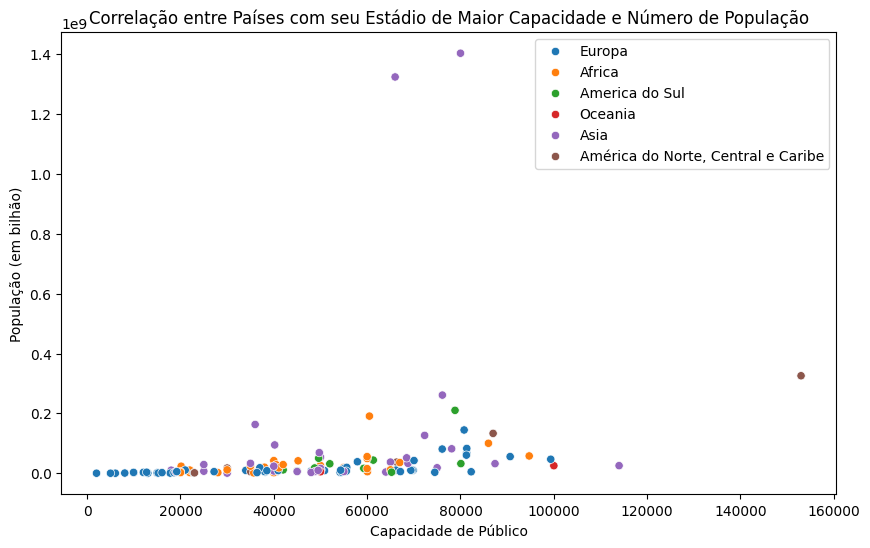

In [41]:
# gráfico de dispersão - correlação de países com seu estádio de maior capacidade de público e número de população
import seaborn as sns

# Filtrar os dados  para incluir países com seu máximo de capacidades de público e populações
filtrodados = df[df["Country"].isin(cap_max_country.index) & df["Country"].isin(pop_max_country.index)]

# Agregar os dados para exibir somente um ponto por país (o maior)
dados_agregados = filtrodados.groupby("Country").max()

plt.figure(figsize=(10, 6))  # Define o tamanho da figura
#palette = sns.color_palette("husl", 6)

sns.scatterplot(x="Capacity",
                y="Population",
                hue="Continent",  # Agrupar os pontos pela coluna "Continent"
                data=dados_agregados,
                palette="tab10"
               )

plt.title("Correlação entre Países com seu Estádio de Maior Capacidade e Número de População")
plt.ylabel("População (em bilhão)")
plt.xlabel("Capacidade de Público")

#plt.xticks(rotation=45)  # Rotaciona as informações do eixo x em 45 graus

# Definir manualmente os limites do eixo x
#plt.xlim(0, 160000)

plt.legend()  # Mostrar a legenda
plt.show()

**Apesar de leve, o gráfico de dispersão apresenta uma correlação positiva, onde demonstra que quanto maior a população, maior será seu estádio**. Mas também há pontos discrepantes como China e Índia, localizados no continente asiático, esses países superam a casa de 1 bilhão habitantes e seus estádios de maior capacidade não chegam na casa de 100 mil pessoas. O que evidencia outros motivos para se ter um estádio de grandes públicos e não somente o tamanho da sua população.

Prosseguindo com as visualizações de dados, vamos transformar alguns insights que identificamos na etapa de análise de dados em gráficos, ter isso em algum tipo de visualização irá nos permitir maior entendimento das informações. Nosso segundo gráfico será um gráfico de barras onde exibirá os continentes com mais estadios e em seguida países com a mesma informação.

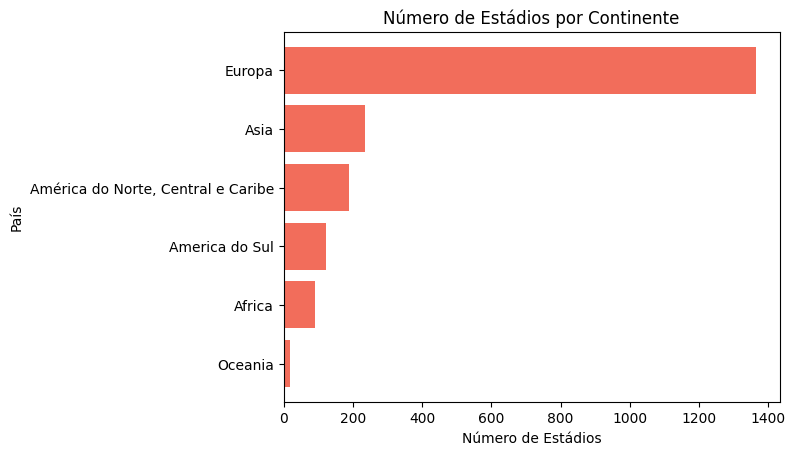

In [42]:
# chart # número de estádio por continente
df["Continent"].value_counts().sort_values(ascending=True).tail(6).plot(kind="barh", width=0.8, color="#f26d5b")

plt.title("Número de Estádios por Continente")
plt.xlabel("Número de Estádios")
plt.ylabel("País")

plt.show()

In [43]:
# frequência relativa de número de estádios por continente
freq_rel_con = (df["Continent"].value_counts() / df["Stadium"].count()) * 100
freq_rel_estadios_con = freq_rel_con.round(2)
print(freq_rel_estadios_con)

Continent
Europa                                67.39
Asia                                  11.66
América do Norte, Central e Caribe     9.39
America do Sul                         6.13
Africa                                 4.50
Oceania                                0.94
Name: count, dtype: float64


Com um cálculo de frequência relativa, conseguimos identificar que a **europa absorve mais de 67% dos estádios** do nosso DataFrame. O que fica claro tudo que vimos até aqui, é lá onde está a maioria dos estádios, em seguida temos a **ásia com mais de 11%** uma diferença de mais de 55% entre o primeiro e o segundo colocado. **américa do norte, central e caribe** aparece como o terceiro continente que mais tem estádios, **possuem mais de 9%**, **américa do sul** vem na sequência com **6,13%** e fechando o quinto e sexto lugar temos a **áfrica** com **4,50%** e a **oceania** com menos de **1%** dos estádios.

Chegou o momento de apresentar esses números por países.

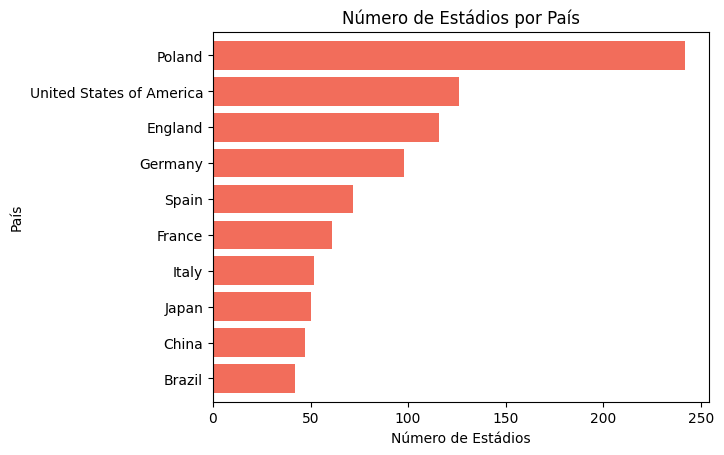

In [44]:
# chart # número de estádio por país - top 10
df["Country"].value_counts().sort_values(ascending=True).tail(10).plot(kind="barh", width=0.8, color="#f26d5b")

plt.title("Número de Estádios por País")
plt.xlabel("Número de Estádios")
plt.ylabel("País")

plt.show()

Como visto anteriormente, encabeçando o continente europeu a **Polônia domina em número de estádios, são mais de 240**, 4 dos 5 primeiros países dessa categoria são pertecentes ao continente europeu.

Com o gráfico de barras isso fica evidente, mas que tal visualizarmos esses números através de um mapa??? Não apenas um mapa estático, vamos construir um mapa dinâmico e para isso vamos usar a biblioteca `Plotly`.

In [45]:
# instalar biblioteca ploty
!pip install plotly -q

In [46]:
# importar biblioteca ploty
import plotly.express as px

# Calcular o número de estádios por país
estadios_por_pais = df.groupby(["Country", "Continent"]).size().reset_index(name='Number of Stadiums')

# Criar o gráfico de mapa
fig = px.choropleth(estadios_por_pais,
                    locations="Country",
                    locationmode='country names',
                    color="Number of Stadiums",
                    hover_name="Country",
                    hover_data=["Country", "Continent", "Number of Stadiums"],  # Adiciona o número de estádios ao hover
                    color_continuous_scale=px.colors.sequential.Reds,
                    title="<b><span style='font-size:25px'>Número de Estádios por País</span></b>",
                    width=900,  # Largura da figura
                    height=500) # Altura da figura

# Ajustar o layout do título para centralizar
fig.update_layout(title_x=0.1, title_font_color='black')

# Mostrar o gráfico
fig.show()


Através desse mapa conseguimos visualizar não apenas os 10 primeiros, mas todos países com seu número de estádios, **basta passar o cursor do mouse em cima do mapa que ele irá exibir o nome e a quantidade de estádios do país**. Além disso, quanto maior a intensidade da cor, maior o número de estádios o país possui.

Seguindo com o números de estádios, vamos gerar um gráfico que apresente aqueles países de maior média de capacidade de público.

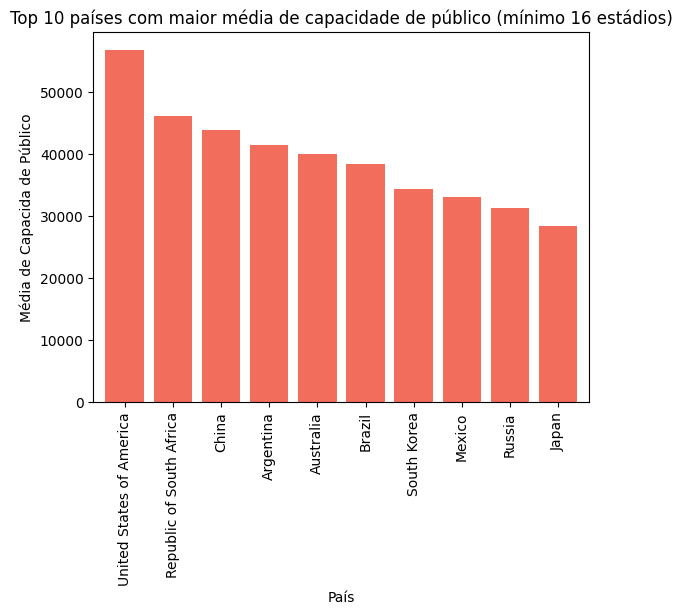

In [47]:
# Top 10 países com maior média de capacidade com no mínimos 16 estádios
media_capacidade_por_pais = df_filtrado.groupby("Country")["Capacity"].mean().round(2).sort_values(ascending=False).head(10).plot(kind="bar", width=0.8, color="#f26d5b")

plt.title("Top 10 países com maior média de capacidade de público (mínimo 16 estádios)")
plt.xlabel("País")
plt.ylabel("Média de Capacida de Público")

plt.show();

**Estados Unidos** é o país de maior média de capacidade de público, eles possuem uma média de **56 mil e 748 lugares**, o que me surpreendeu nessa análise foi ter a **África do Sul** na segunda colocação dessa categoria, o país africano tem uma média de mais de **46 mil lugares**, eles aparecem na frente da **China** que aparece na terceira colocação com uma média de **43 mil e 881 lugares**, na sequência temos **Argentina** e **Austrália** na quarta e quinta colocação respectivamente, o pais argentino tem uma média de **41 mil e 476 lugares**, já o australiano uma média de quase **40 mil**. Para fechar, pois se trata do nosso país, o **Brasil** aparece na sexta colocação com uma média de **38 mil e 439 lugares.**

Hora de apresentar em gráfico os países de melhor número de `Capacity_per_Population`.

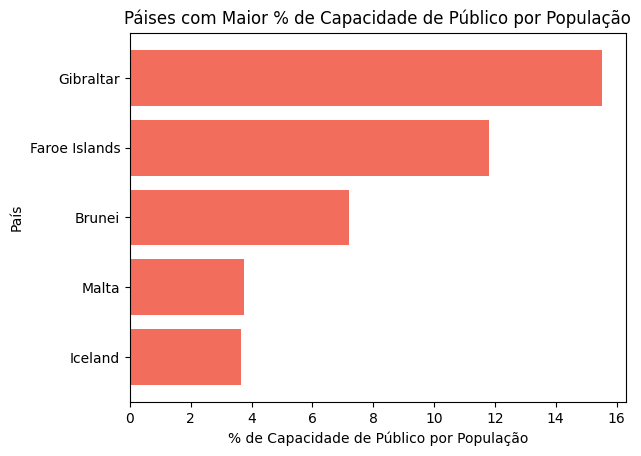

In [48]:
# maior capacity per population por país
df.groupby("Country")["Capacity_per_Population"].max().sort_values(ascending=True).tail(5).plot(kind="barh", width=0.8, color="#f26d5b")

plt.title("Páises com Maior % de Capacidade de Público por População")
plt.xlabel("% de Capacidade de Público por População")
plt.ylabel("País")

plt.show()

**Gilbratar, Ilhas Faroe, Brunei, Malta e Islândia**. O que esses 4 países europeus e um asiático (Brunei) tem em comum? Eles são os 5 países que maior porcentagem de habitantes absorvem em seu estádio de maior capacidade. Portanto, apesar de não parecer, pois são países de pouca  expressão esportivamente, eles possuem estádios e acredito que vale a visita, vou deixar até o nome deles aqui:

* Gilbratar - Victoria Stadium
* Ilhas Faroe - Tórsvøllur
* Brunei - Stadium Negara Hassanal Bolkiah
* Malta - Ta’ Qali Stadium
* Islândia - Laugardalsvöllur

Agora, fugindo da nossa análise principal, e para fechar nosso projeto, vamos filtrar nosso DataFrame para somentes estádios do Brasil e avaliar qual é o número de estádios por cidade.

In [49]:
# número de estádios localizados por cidades no Brasil - Top 10
df[df["Country"] == "Brazil"].groupby("City").size().sort_values(ascending=False).head(10)

City
São Paulo            5
Salvador da Bahia    3
Rio de Janeiro       3
Recife               3
Pôrto Alegre         3
Campinas             2
Cúritiba             2
Fortaleza            2
Belo Horizonte       2
Barueri              1
dtype: int64

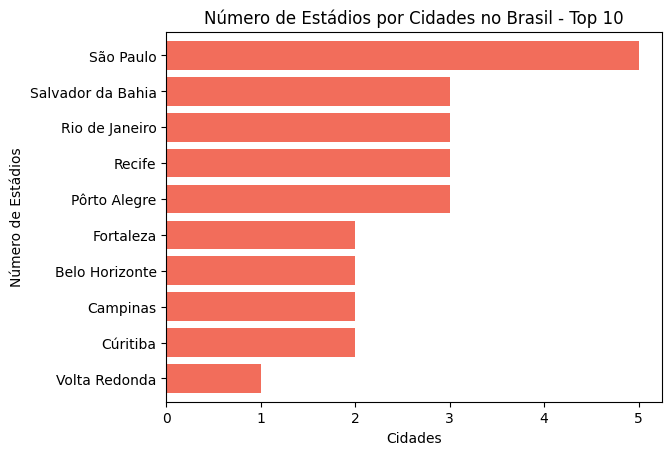

In [50]:
# número de estádios localizados por cidades no Brasil - Top 10
df[df["Country"] == "Brazil"].groupby("City").size().sort_values(ascending=True).tail(10).plot(kind="barh", width=0.8, color="#f26d5b")

plt.title("Número de Estádios por Cidades no Brasil - Top 10")
plt.xlabel("Cidades")
plt.ylabel("Número de Estádios")

plt.show();

A cidade de **São Paulo** registra o maior número de estádios, ao todo são 5, na sequência temos varias cidades com 3 estádios, são elas: **Salvador**, **Rio de Janeiro**, **Recife** e **Porto Alegre**, encerra as cidades com mais de 1 estádio **Fortaleza**, **Belo Horizonte**, **Campinas** e **Curitiba**. Vamos deixar abaixo esses estádios em mais detalhes e por ordem de capacidade de público.

In [51]:
df[df["Country"] == "Brazil"].sort_values("Capacity", ascending=False)

,Confederation,Stadium,City,HomeTeams,Capacity,Country,IOC,Population,Continent,Capacity_per_Population
184,CONMEBOL,Maracanã,Rio de Janeiro,"Flamengo, Botafogo, Fluminense, Vasco",78838,Brazil,BRA,210147125,America do Sul,0.037516
172,CONMEBOL,Estádio Nacional,Brasilia,Brasília FC,72888,Brazil,BRA,210147125,America do Sul,0.034684
162,CONMEBOL,Estádio do Morumbi,São Paulo,FC São Paulo,67428,Brazil,BRA,210147125,America do Sul,0.032086
157,CONMEBOL,Estádio Castelão,Fortaleza,"Fortaleza, Ceará, Ferroviário",63903,Brazil,BRA,210147125,America do Sul,0.030409
170,CONMEBOL,Estádio Mineirão,Belo Horizonte,"Cruzeiro, Mineiro",62160,Brazil,BRA,210147125,America do Sul,0.029579
150,CONMEBOL,Arena do Grêmio,Pôrto Alegre,Gręmio,60540,Brazil,BRA,210147125,America do Sul,0.028808
160,CONMEBOL,Estádio do Arruda,Recife,Santa Cruz,53289,Brazil,BRA,210147125,America do Sul,0.025358
153,CONMEBOL,Estádio Beira-Rio,Pôrto Alegre,Internacional,51800,Brazil,BRA,210147125,America do Sul,0.024649
174,CONMEBOL,Estádio Olímpico Monumental,Pôrto Alegre,Gręmio,51081,Brazil,BRA,210147125,America do Sul,0.024307
178,CONMEBOL,Estádio Serra Dourada,Goiânia,"Goiás, Vila Nova, Atlético Goianiense, Goiânia",50049,Brazil,BRA,210147125,America do Sul,0.023816


## Conclusão

Antes de tudo, gostaria de compartilhar que essa análise me proporcionou muito aprendizado, viajei o mundo através dos seus estádios e pude aprender muitas coisas através dos seus números.

Como visto, o notebook requeriu pouca necessidade de limpeza de dados, foi necessário algumas etapas de modelagem de dados adicionando novas colunas e corrigindo algumas mudanças que essas manobras geraram, exemplo o país Austrália que foi preciso transferir-lô para o continente da oceania, onde até então estava situado no continente asiático.

O projeto não teve a intenção de criar nenhum tipo de modelo ou previsão. O propósito do projeto foi através da análise descritiva entender o cenário de estádios pelo mundo, e extrair insights relavantes de suas características e demandas. Adicionando a análise quantitativa,também se foi necessário uma análise qualitativa em sites espcializados para contribuir para uma análise mais detalhada. As referências foram adicionadas no final do notebook.

Depois de alguns dias de estudos, consultas e muito trabalhado, a análise foi concluída e a seguir visualizará todos os insights mais relevantes que essa análise nos proporcionou. Se prepare, tem muita coisa interessante.

Obrigado por você que chegou até aqui, se tiver alguma dica, comentário ou sugestão, estou de todo ouvidos, só me chamar no LinkedIn [Eric Fruchi](https://www.linkedin.com/in/ericfruchi/).

## Insights

* O notebook analisou **2024 estádios, esses distribuídos entre 6 confederações, 6 continentes e 129 países**.
* Quase todos os estádios possuem um dono ou time proprietário, **apenas 204 estádios não podem chamar um dono de seu**.
* **Europa foi o continente com mais países analisados**, o continente forneceu para a análise **52 países**, na sequência vieram **ásia com 32, áfrica com 27, américa do sul  10, américa do norte, central e caribe 7 e fechando os números de países por continente, temos a oceania que apresentou apenas 1 país**.
* **A média de estádio por país é de 16**, essa média é elevada principalmente muito por conta de países da europa: **Polônia que sozinha possui 242 estádios, depois temos o não europeu Estados Unidos com 126, voltando a europa temos a Inglaterra com 116, Alemanha com 98 e Espanha que fecha os cinco primeiros com 72 estádios.**
* **Estados Unidos é o país de maior média de capacidade de público, eles possuem uma média de 56 mil e 748 lugares**, seguidos pela **África do Sul** que aparece na segunda colocação da categoria, o país africano tem uma média de mais de **46 mil lugares**, eles aparecem na frente da **China** que aparece na terceira colocação com uma média de **43 mil e 881 lugares**, na sequência temos **Argentina** e **Austrália** na quarta e quinta colocação respectivamente, o pais argentino tem uma média de **41 mil e 476 lugares**, já o australiano uma média de quase **40 mil**. O **Brasil aparece na sexta colocação com uma média de 38 mil e 439 lugares.**
* 5 dos 6 continentes tem sua maior capacidade de público próximo da casa de 100 mil pessoas, o continente que destoa um pouco disso é a américa do sul, que tem sua maior capacidade na casa de 80 mil.
* **Estádio de maior capacidade de público: Bristol Motor Speedway (autódromo)**, localizado em Tennessee, Estados Unidos, com 153 mil lugares.
* **Estádio de menor capacidade de público: Stadion OSiR Skałka** - 244 lugares, localizado na Polônia.
* **Gilbratar é onde está localizado o estádio que mais absorve proporcionalmente sua população, precisamente 15,53% da população do país cabe no estádio**. Em seguida vem **Ilhas Faroe** com 11,82% de absorção de toda sua população em seu estadio, depois termos **Brunei** com 7,19%, **Malta** com 3,74% e fechando os cinco primeiros temos a **Islândia** com 3,66%.
* **Apesar de leve, o gráfico de dispersão apresenta uma correlação de quanto maior a população, maior será seu estádio**. Mas também há pontos discrepantes como China e Índia, localizados no continente asiático, esses países superam a casa de 1 bilhão habitantes e seus estádios de maior capacidade não chegam na casa de 100 mil pessoas. O que evidencia outros motivos para se ter um estádio de grandes públicos e não somente o tamanho da sua população.
* **A cidade de São Paulo** é onde ficar maior parte de estádios registrados no Brasil, a cidade apresenta **5 estádios**.


## Referências

* https://pt.wikipedia.org/wiki/Bristol_Motor_Speedway
* https://pl.wikipedia.org/wiki/Stadion_Ska%C5%82ka_im._Paw%C5%82a_Waloszka_w_%C5%9Awi%C4%99toch%C5%82owicach
* https://pt.wikipedia.org/wiki/Victoria_Stadium
* https://pt.wikipedia.org/wiki/Est%C3%A1dio_FNB
* https://dusc.net/about-us/
* https://pt.wikipedia.org/wiki/Wroc%C5%82awski_Klub_Sportowy_%C5%9Al%C4%85sk_Wroc%C5%82aw_Sp%C3%B3%C5%82ka_Akcyjna
* https://en.wikipedia.org/wiki/Sydney_Olympic_Park_Athletic_Centre


Créditos da foto de capa: https://unsplash.com/photos/white-and-blue-stadium-during-daytime-YB-e6x1vN58